# Import Library

In [ ]:
from torch.nn import init
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import numpy as np


# Evaluation Metric

In [2]:

# SR : Segmentation Result
# GT : Ground Truth

def get_accuracy(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)
    corr = torch.sum(SR==GT)
    tensor_size = SR.size(0)*SR.size(1)*SR.size(2)*SR.size(3)
    acc = float(corr)/float(tensor_size)

    return acc

def get_sensitivity(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FN : False Negative
    TP = ((SR==1)+(GT==1))==2
    FN = ((SR==0)+(GT==1))==2

    SE = float(torch.sum(TP))/(float(torch.sum(TP+FN)) + 1e-6)     
    
    return SE

def get_specificity(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TN : True Negative
    # FP : False Positive
    TN = ((SR==0)+(GT==0))==2
    FP = ((SR==1)+(GT==0))==2

    SP = float(torch.sum(TN))/(float(torch.sum(TN+FP)) + 1e-6)
    
    return SP

def get_precision(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FP : False Positive
    TP = ((SR==1)+(GT==1))==2
    FP = ((SR==1)+(GT==0))==2

    PC = float(torch.sum(TP))/(float(torch.sum(TP+FP)) + 1e-6)

    return PC

def get_F1(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SE = get_sensitivity(SR,GT,threshold=threshold)
    PC = get_precision(SR,GT,threshold=threshold)

    F1 = 2*SE*PC/(SE+PC + 1e-6)

    return F1

def get_JS(SR,GT,threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    GT = GT == torch.max(GT)
    
    Inter = torch.sum((SR+GT)==2)
    Union = torch.sum((SR+GT)>=1)
    
    JS = float(Inter)/(float(Union) + 1e-6)
    
    return JS

def get_DC(SR,GT,threshold=0.5):
    # DC : Dice Coefficient
    SR = SR > threshold
    GT = GT == torch.max(GT)

    Inter = torch.sum((SR+GT)==2)
    DC = float(2*Inter)/(float(torch.sum(SR)+torch.sum(GT)) + 1e-6)

    return DC

# Utils


In [3]:
def check_accuracy_binary(loader,model,device):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(
        f'Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}'
    )
    print(f'Dice score: {dice_score/len(loader)}')
    model.train()
    return dice_score/len(loader)


def save_predictions_as_imgs(loader, model, device, folder="saved_images/"):
    if not os.path.exists(folder):
        os.makedirs(folder)
    num_examples = 0
    
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        
        for i in range(preds.size(0)):  # Iterate over each image in the batch
            torchvision.utils.save_image(preds[i], os.path.join(folder, f"pred_{idx}_{i}.png"))
            torchvision.utils.save_image(y[i].unsqueeze(0), os.path.join(folder, f"mask_{idx}_{i}.png"))  # unsqueeze adds a channel dimension to the tensor
            num_examples += 1
            if num_examples == 10:
                model.train()
                return

def get_unique_foldername(base_foldername):
    if not os.path.isdir(base_foldername):
        return base_foldername
    
    base, ext = os.path.splitext(base_foldername)
    i = 1
    new_foldername = f"{base}_{i}{ext}"
    
    while os.path.isdir(new_foldername):
        i += 1
        new_foldername = f"{base}_{i}{ext}"
    
    return new_foldername

def create_unique_folders(base_foldername1): #(base_foldername1, base_foldername2):
    # Get unique folder names
    unique_foldername1 = get_unique_foldername(base_foldername1)
    #unique_foldername2 = get_unique_foldername(base_foldername2)
    
    # Create the folders if they don't exist
    os.makedirs(unique_foldername1, exist_ok=True)
    #os.makedirs(unique_foldername2, exist_ok=True)
    
    print(f"Folder created at: {unique_foldername1}")
    #print(f"Folder 2 created at: {unique_foldername2}")
    
    return unique_foldername1 #, unique_foldername2


# U-Net Network Architecture

In [ ]:

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1

class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


# U-Net Network

class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


# Network Testing

In [5]:
# test the model
# dummy = torch.randn((3, 3, 160, 160))  

# U_Netmodel = U_Net(img_ch=3,output_ch=1)
# print(U_Netmodel(dummy).shape)

# R2U_Netmodel = R2U_Net(img_ch=3,output_ch=1)
# print(R2U_Netmodel(dummy).shape)

# AttU_Netmodel = AttU_Net(img_ch=3,output_ch=1)
# print(AttU_Netmodel(dummy).shape)

# R2AttU_Netmodel = R2AttU_Net(img_ch=3,output_ch=1)
# print(R2AttU_Netmodel(dummy).shape)

# Dataset Preparation and Load

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np


class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        # read the image and the mask (label), and store them in the form of numpy arrays (for the albumentations library)
        image = np.array(Image.open(img_path).convert("RGB")) # we might not need to do this because the images are loaded as RGB by default
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # convert("L") will convert the image to grayscale
        # binarize the mask
        mask[mask == 255.0] = 1.0

        # apply the transformations if they exist
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        return image, mask 

# Image Augmentation 

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_image_dir = 'data/train'
train_mask_dir = 'data/train_masks'
val_image_dir = 'data/val'
val_mask_dir = 'data/val_masks'
## Dataset hyperparameters
batch_size = 32
image_height = 320
image_width = 480
pin_memory = True

train_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # this will only divide by 255 (since mean = 0 and std = 1)
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

# for the validation transforms, we will only resize and normalize without any augmentations
val_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

train_dataset = CarvanaDataset(image_dir=train_image_dir,mask_dir=train_mask_dir, transform=train_transform)
val_dataset = CarvanaDataset(image_dir=val_image_dir,mask_dir=val_mask_dir, transform=val_transform)

c:\Users\afiq.abdullah\.conda\envs\master_env\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
len(train_dataset), len(val_dataset)

(4600, 488)

In [9]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 320, 480]), torch.Size([320, 480]))

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

torch.Size([32, 3, 320, 480]) torch.Size([32, 320, 480])


# Model Initializations

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_accuracy = 0

## Model hyperparameters
in_channels = 3
out_channels = 1
learning_rate = 1e-2  #Default value 1e-4
num_epochs = 2

Model_Train=(U_Net,R2U_Net,AttU_Net,R2AttU_Net)

model = Model_Train[0](img_ch=in_channels,output_ch=out_channels).to(device)
# criterion = nn.CrossEntropyLoss() # we will use this loss function if we have multiple classes (out_channels > 1)
criterion = nn.BCEWithLogitsLoss() # binary cross entropy with logits loss (it expects the logits, and it will apply the sigmoid function by itself), the sigmoid is applied because we have only 1 channel, and each pixel will have a value between 0 and 1 that represents the probability of that pixel being class 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scalar
scaler = torch.cuda.amp.GradScaler() # this will help us to use mixed precision training

use_scheduler = True
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)


# if we want to load a model and continue training
load_model = False
if load_model:
    checkpoint = torch.load("model.pth")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    best_accuracy = checkpoint["best_accuracy"]
    print("=> Loaded model with accuracy {:.2f}".format(best_accuracy))

C:\Users\afiq.abdullah\AppData\Local\Temp\ipykernel_13928\2236731960.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # this will help us to use mixed precision training


# Empty CUDA cache

In [12]:
torch.cuda.empty_cache()

# Training Session

In [13]:
# Initialize lists to track metrics
train_losses, val_losses = [], []
val_accuracies, val_precisions, val_recalls, val_f1scores, val_aucs = [], [], [], [], []

# Folder management
basefolder = "runs"
foldertrain = create_unique_folders(basefolder + "/train/exp")

# Define the function for training step
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    train_examples = 0
    tk0 = tqdm(train_loader, total=len(train_loader), desc="Training")
    
    for batch_idx, (images, masks) in enumerate(tk0):
        images, masks = images.to(device), masks.float().unsqueeze(1).to(device)
        
        with torch.cuda.amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
        
        running_loss += loss.item()
        train_examples += images.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update progress bar
        tk0.set_postfix(loss=(running_loss / train_examples))
    
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss

# Define the function for validation step
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    val_examples = 0
    all_preds, all_targets, all_probs = [], [], []
    
    tk1 = tqdm(val_loader, total=len(val_loader), desc="Validation")
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tk1):
            images, masks = images.to(device), masks.float().unsqueeze(1).to(device)
            
            preds = model(images)
            loss = criterion(preds, masks)
            running_loss += loss.item()
            val_examples += images.size(0)

            # Apply sigmoid and convert predictions to binary
            preds_sigmoid = torch.sigmoid(preds)
            preds_binary = (preds_sigmoid > 0.5).float()

            # Collect predictions, targets, and probabilities for metrics
            all_probs.append(preds_sigmoid.cpu().numpy())
            all_preds.append(preds_binary.cpu().numpy())
            all_targets.append(masks.cpu().numpy())
            
            tk1.set_postfix(loss=(running_loss / val_examples))

    # Flatten the predictions, targets, and probabilities for metric calculations
    all_probs = np.concatenate(all_probs).flatten()
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()

    # Calculate validation metrics
    val_loss = running_loss / len(val_loader)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)

    return val_loss, precision, recall, f1, auc

# Function to train and validate the model for multiple epochs
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, num_epochs, early_stopping_patience=None):
    best_accuracy = 0.0
    best_auc = 0.0
    best_f1 = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        train_losses.append(train_loss)
        
        # Validation phase
        val_loss, precision, recall, f1, auc = validate_one_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1scores.append(f1)
        val_aucs.append(auc)

        # Calculate accuracy after validation
        accuracy = check_accuracy_binary(val_loader, model, device)
        val_accuracies.append(accuracy)

        # Print metrics summary
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        # Save model checkpoints based on the best metric (you can choose accuracy, AUC, or F1)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, optimizer, best_accuracy, foldertrain, "best_accuracy.pth")

        # if auc > best_auc:
        #     best_auc = auc
        #     save_model(model, optimizer, best_auc, foldertrain, "best_auc.pth")
        # if f1 > best_f1:
        #     best_f1 = f1
        #     save_model(model, optimizer, best_f1, foldertrain, "best_f1.pth")
        
        # Save the model after every epoch
        save_model(model, optimizer, best_accuracy, foldertrain, "last.pth")

        # Save prediction images every 5 epochs
        if epoch % 5 == 0:
            save_predictions_as_imgs(val_loader, model, device, folder=foldertrain + "/saved_images/")
        
        # Scheduler step
        if use_scheduler:
            scheduler.step()

        # Early stopping check (if enabled)
        if early_stopping_patience:
            if val_loss < min(val_losses):
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

# Helper function to save model checkpoints
def save_model(model, optimizer, metric, foldertrain, filename):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "metric": metric
    }
    torch.save(checkpoint, foldertrain + "/" + filename)


# Initialize and run the training loop
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, num_epochs, early_stopping_patience=5)


Folder created at: runs/train/exp_22
Epoch 1/2


Training:   0%|          | 0/144 [00:00<?, ?it/s]C:\Users\afiq.abdullah\AppData\Local\Temp\ipykernel_13928\1675345141.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 16/16 [00:41<00:00,  2.60s/it, loss=0.00152]


Got 73737697/74956800 with acc 98.37
Dice score: 0.9616530537605286
Train Loss: 0.1209, Val Loss: 0.0464, Accuracy: 0.9617, Precision: 0.9761, Recall: 0.9473, F1: 0.9615, AUC: 0.9982
Epoch 2/2


Training:   0%|          | 0/144 [00:00<?, ?it/s]C:\Users\afiq.abdullah\AppData\Local\Temp\ipykernel_13928\1675345141.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it, loss=0.102] 


Got 31741572/74956800 with acc 42.35
Dice score: 0.43319904804229736
Train Loss: 0.0394, Val Loss: 3.1188, Accuracy: 0.4332, Precision: 0.2710, Recall: 0.9999, F1: 0.4264, AUC: 0.7771


# Train Folder Directory

In [14]:
print(foldertrain)

runs/train/exp_22


# Save training/validation data to Excel

In [15]:
import pandas as pd
import os

# Uncomment or implement this function if you want to ensure the folder exists
# def ensure_folder_exists(foldertrain):
#     if not os.path.exists(foldertrain):
#         os.makedirs(foldertrain)

# Save training/validation data to Excel
def save_metrics_to_excel(foldertrain, train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1scores, val_aucs):
    #ensure_folder_exists(foldertrain)

    # Assuming these lists might contain tensors
    # If not tensors, you can remove .item()
    train_losses = [acc.item() if hasattr(acc, 'item') else acc for acc in train_losses]
    val_losses = [acc.item() if hasattr(acc, 'item') else acc for acc in val_losses]
    val_accuracies = [acc.item() if hasattr(acc, 'item') else acc for acc in val_accuracies]
    val_precisions = [acc.item() if hasattr(acc, 'item') else acc for acc in val_precisions]
    val_recalls = [acc.item() if hasattr(acc, 'item') else acc for acc in val_recalls]
    val_f1scores = [acc.item() if hasattr(acc, 'item') else acc for acc in val_f1scores]
    val_aucs = [acc.item() if hasattr(acc, 'item') else acc for acc in val_aucs]

    # Ensure all lists are the same length
    epochs = list(range(1, len(train_losses) + 1))
    data = {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Val Loss": val_losses,
        "Val Accuracy": val_accuracies,
        "Val Precision": val_precisions,
        "Val Recall": val_recalls,
        "Val F1 Score": val_f1scores,
        "Val AUC": val_aucs
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Define the file path for Excel
    excel_path = os.path.join(foldertrain, "training_metrics.xlsx")

    # Save to Excel using xlsxwriter engine
    try:
        df.to_excel(excel_path, index=False, engine='xlsxwriter')
        print(f"Metrics successfully saved to {excel_path}")
    except Exception as e:
        print(f"Failed to save metrics to Excel: {e}")

In [16]:
save_metrics_to_excel(foldertrain, train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1scores, val_aucs)

Metrics successfully saved to runs/train/exp_22\training_metrics.xlsx


# Generate graphs for the metrics

In [38]:
import matplotlib.pyplot as plt
import os

# Helper function to plot and save a graph
def plot_and_save_graph(x, y, xlabel, ylabel, title, legend_label, filepath, color=None):
    try:
        plt.figure(figsize=(12, 8))
        plt.plot(x, y, label=legend_label, color=color)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(filepath)
        plt.close()  # Close the figure to free memory
        print(f"Graph successfully saved to {filepath}")
    except Exception as e:
        print(f"Failed to generate {title} graph: {e}")

# Function to display the graph
def display_graph(filepath):
    try:
        img = plt.imread(filepath)
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.title(os.path.basename(filepath))  # Show the filename as title
        plt.show()
    except Exception as e:
        print(f"Failed to display graph from {filepath}: {e}")

# Generate graphs for the metrics
def generate_training_graphs(foldertrain, train_losses, val_losses, val_accuracies, val_aucs, val_precisions, val_recalls, val_f1scores):
    # Ensure folder exists
    os.makedirs(foldertrain, exist_ok=True)

    epochs = list(range(1, len(train_losses) + 1))
    
    # Convert tensor-like objects to list
    train_losses = [acc.item() if hasattr(acc, 'item') else acc for acc in train_losses]
    val_losses = [acc.item() if hasattr(acc, 'item') else acc for acc in val_losses]
    val_accuracies = [acc.item() if hasattr(acc, 'item') else acc for acc in val_accuracies]
    val_precisions = [acc.item() if hasattr(acc, 'item') else acc for acc in val_precisions]
    val_recalls = [acc.item() if hasattr(acc, 'item') else acc for acc in val_recalls]
    val_f1scores = [acc.item() if hasattr(acc, 'item') else acc for acc in val_f1scores]
    val_aucs = [acc.item() if hasattr(acc, 'item') else acc for acc in val_aucs]

    # Plot and save Losses (training and validation together)
    plot_and_save_graph(
        epochs, train_losses, "Epochs", "Loss", "Training Loss", 
        "Train Loss", os.path.join(foldertrain, "train_loss_graph.png"), color="blue"
    )
    plot_and_save_graph(
        epochs, val_losses, "Epochs", "Loss", "Validation Loss", 
        "Validation Loss", os.path.join(foldertrain, "val_loss_graph.png"), color="orange"
    )

    # Display Loss Graphs
    display_graph(os.path.join(foldertrain, "train_loss_graph.png"))
    display_graph(os.path.join(foldertrain, "val_loss_graph.png"))

    # Plot and save Accuracy
    plot_and_save_graph(
        epochs, val_accuracies, "Epochs", "Accuracy", "Validation Accuracy Over Epochs", 
        "Validation Accuracy", os.path.join(foldertrain, "accuracy_graph.png"), color="green"
    )
    display_graph(os.path.join(foldertrain, "accuracy_graph.png"))

    # Plot and save AUC
    plot_and_save_graph(
        epochs, val_aucs, "Epochs", "AUC", "Validation AUC Over Epochs", 
        "Validation AUC", os.path.join(foldertrain, "auc_graph.png"), color="purple"
    )
    display_graph(os.path.join(foldertrain, "auc_graph.png"))

    # Plot and save Precision
    plot_and_save_graph(
        epochs, val_precisions, "Epochs", "Precision", "Validation Precision Over Epochs", 
        "Validation Precision", os.path.join(foldertrain, "precision_graph.png"), color="blue"
    )
    display_graph(os.path.join(foldertrain, "precision_graph.png"))

    # Plot and save Recall
    plot_and_save_graph(
        epochs, val_recalls, "Epochs", "Recall", "Validation Recall Over Epochs", 
        "Validation Recall", os.path.join(foldertrain, "recall_graph.png"), color="orange"
    )
    display_graph(os.path.join(foldertrain, "recall_graph.png"))

    # Plot and save F1 Score
    plot_and_save_graph(
        epochs, val_f1scores, "Epochs", "F1 Score", "Validation F1 Score Over Epochs", 
        "Validation F1 Score", os.path.join(foldertrain, "f1score_graph.png"), color="red"
    )
    display_graph(os.path.join(foldertrain, "f1score_graph.png"))



Graph successfully saved to runs/train/exp_22\train_loss_graph.png
Graph successfully saved to runs/train/exp_22\val_loss_graph.png


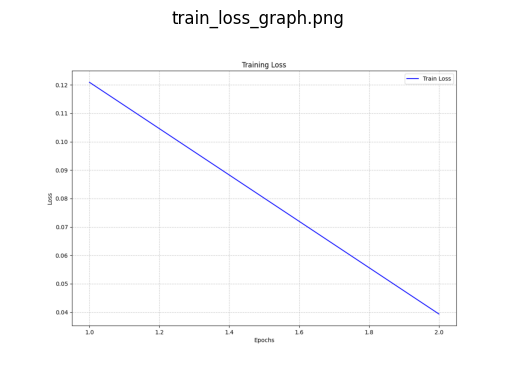

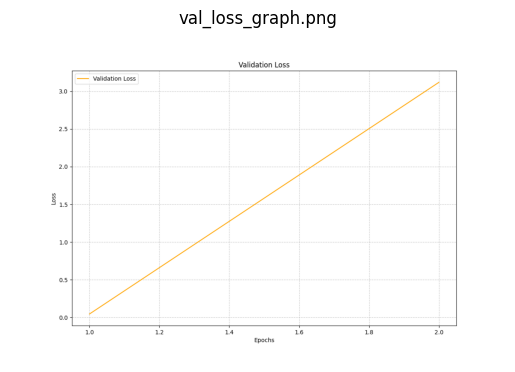

Graph successfully saved to runs/train/exp_22\accuracy_graph.png


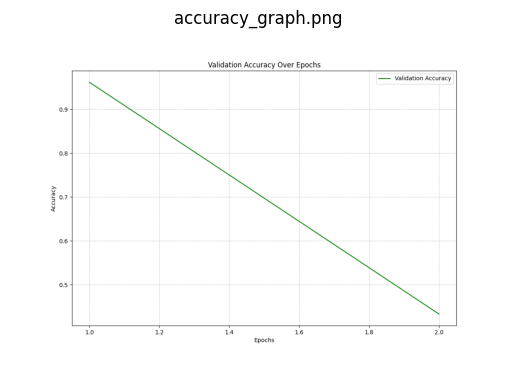

Graph successfully saved to runs/train/exp_22\auc_graph.png


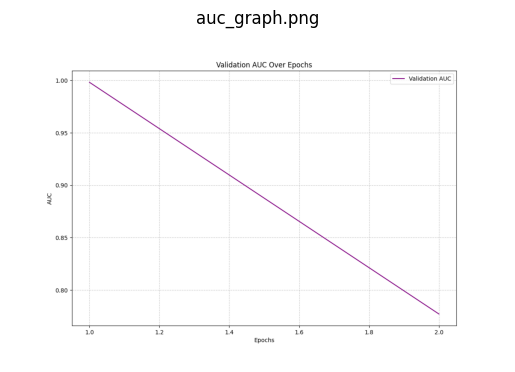

Graph successfully saved to runs/train/exp_22\precision_graph.png


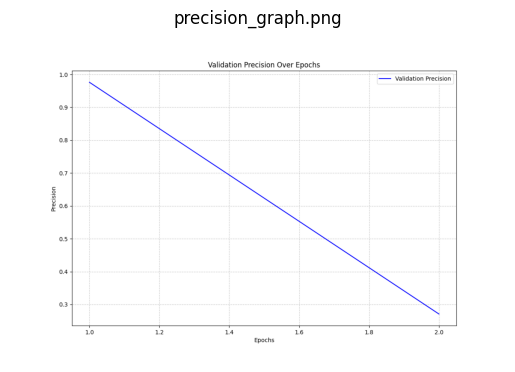

Graph successfully saved to runs/train/exp_22\recall_graph.png


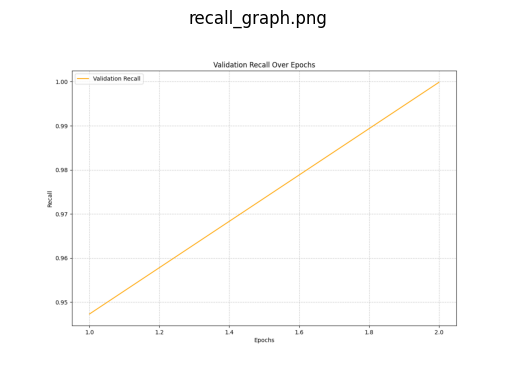

Graph successfully saved to runs/train/exp_22\f1score_graph.png


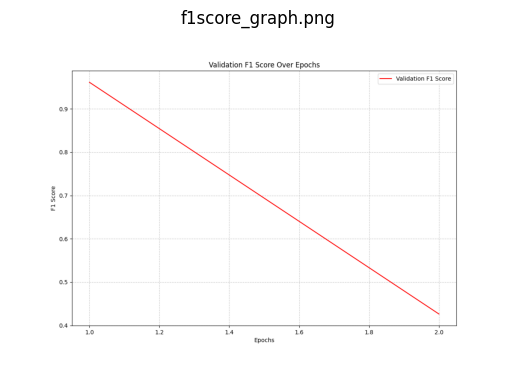

In [39]:
generate_training_graphs(foldertrain, train_losses, val_losses, val_accuracies, val_aucs,val_precisions,val_recalls,val_f1scores)

# Prediction 

In [42]:
import numpy as np
import pandas as pd
import time

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[:-1:2]
    
    return ' '.join(str(x) for x in runs)

In [45]:
TEST_DIR =  'data/test1'
THRESHOLD = 0.5
import torchvision.transforms.functional as TF

# Dataset
class CarvanaTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, self.images[index])
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations['image']

        return img_name, image


test_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(), 
    ]
)
   
test_set = CarvanaTestDataset(
    image_dir=TEST_DIR,
    transform=test_transform
)    


test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)
    
# Model
checkpoint = torch.load(foldertrain +'/best_accuracy.pth')
model = U_Net(img_ch=3, output_ch=1).to(device)
model.load_state_dict(checkpoint['state_dict'])

model.eval()

# Predictions
all_predictions = []
for img_names, x in tqdm(test_loader):
    x = x.to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > THRESHOLD).float()   
    preds = TF.resize(
        preds, size=(1280, 1918), interpolation=TF.InterpolationMode.NEAREST
    )
    
    # Encoding
    for idx in range(len(img_names)):
        encoding = rle_encode(preds[idx].squeeze().cpu())
        all_predictions.append([img_names[idx], encoding])

C:\Users\afiq.abdullah\AppData\Local\Temp\ipykernel_13928\323302613.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(foldertrain +'/best_accuracy

In [46]:
def display_predictions(original_img, predicted_mask, save_path=None, img_name='image'):
    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Save the figure if a save path is provided
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(os.path.join(save_path, f"{img_name}_prediction.png"), bbox_inches='tight')
        print(f"Saved combined image and mask at: {os.path.join(save_path, f'{img_name}_prediction.png')}")

    plt.show()

Folder created at: runs/predict/exp_1


  0%|          | 0/1 [00:00<?, ?it/s]

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\000aa097d423_01.jpg_prediction.png


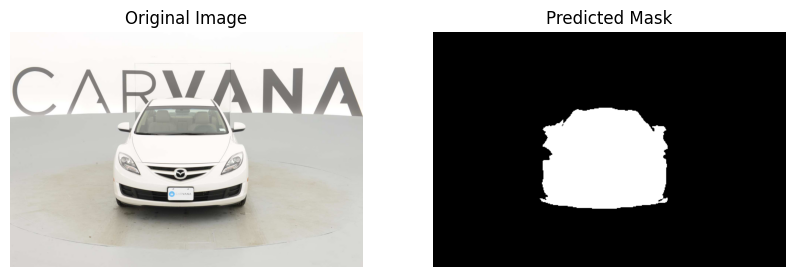

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\000aa097d423_16.jpg_prediction.png


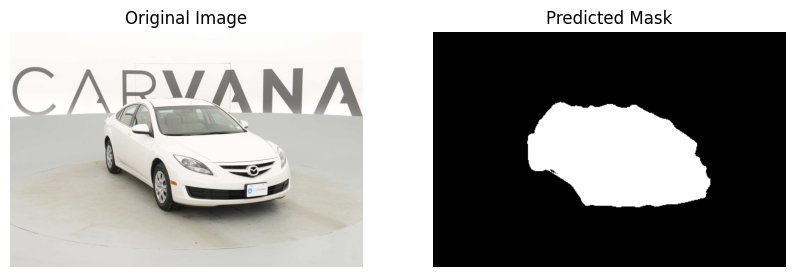

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\000f19f6e7d4_15.jpg_prediction.png


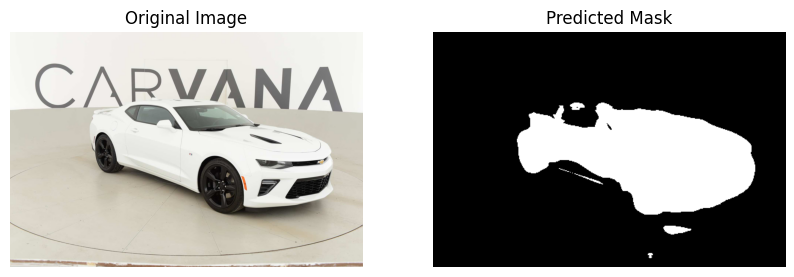

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00ad56bf7ee6_14.jpg_prediction.png


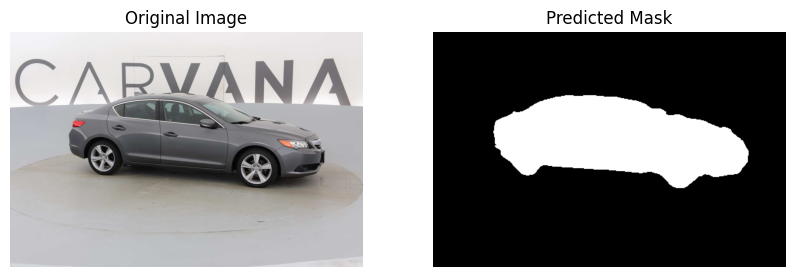

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00afb946a54c_13.jpg_prediction.png


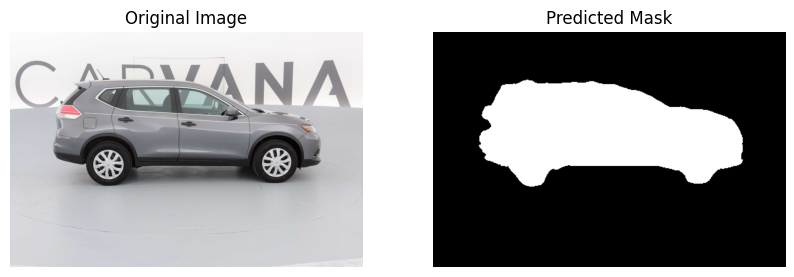

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00b6aee52419_12.jpg_prediction.png


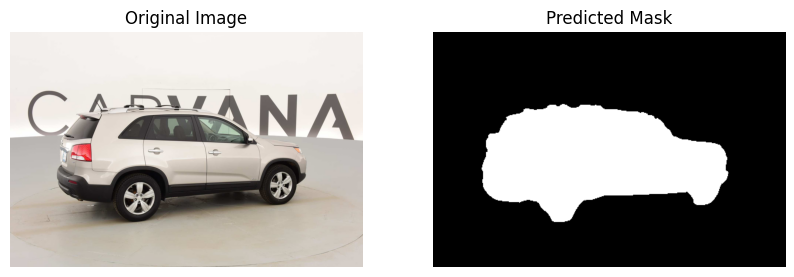

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00c07d49f4c5_11.jpg_prediction.png


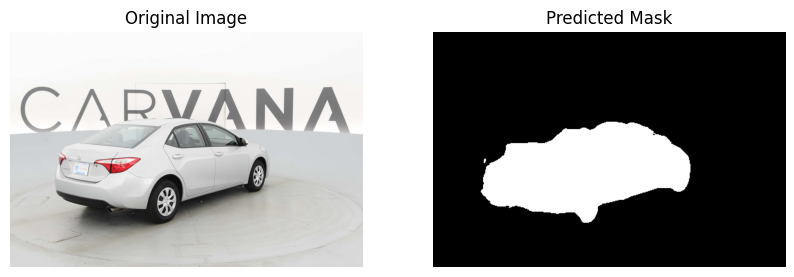

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00d3de919651_10.jpg_prediction.png


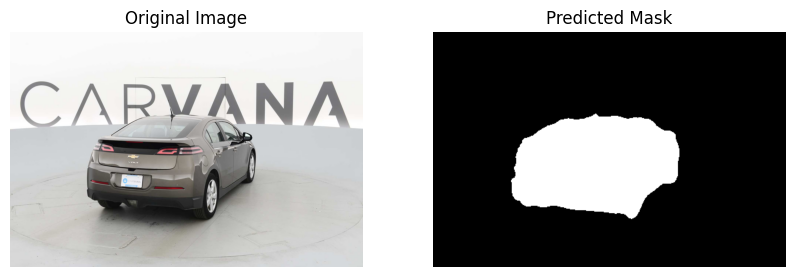

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00ea6d495e8f_09.jpg_prediction.png


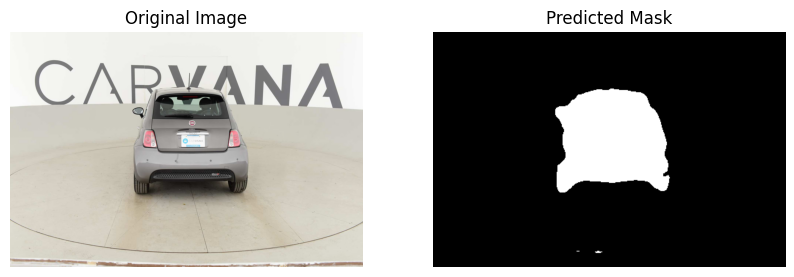

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00ea92389675_08.jpg_prediction.png


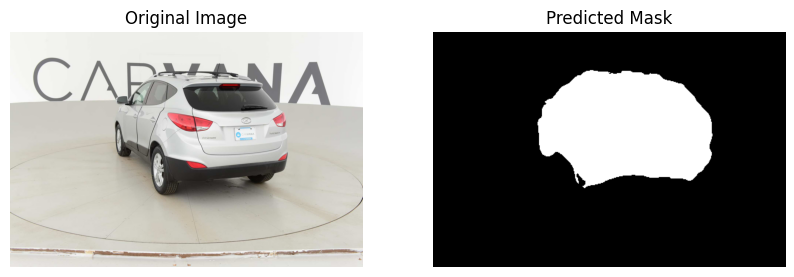

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00f145d0d769_07.jpg_prediction.png


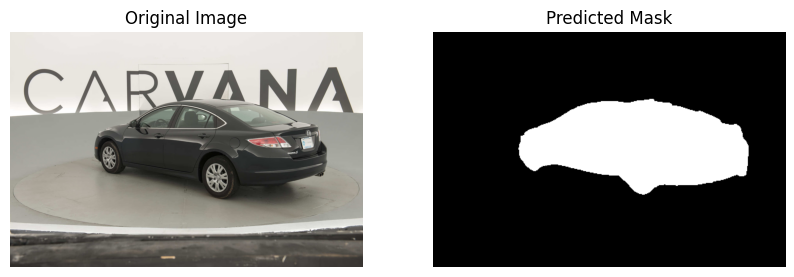

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\00fb5d5806c7_06.jpg_prediction.png


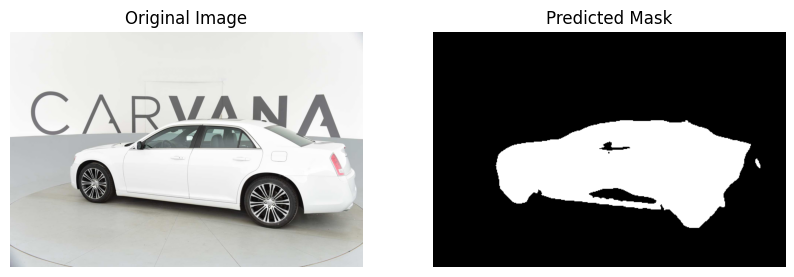

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\0a0e3fb8f782_05.jpg_prediction.png


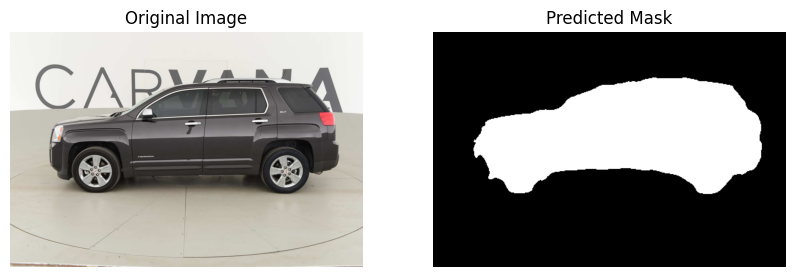

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\0a2bbd5330a2_04.jpg_prediction.png


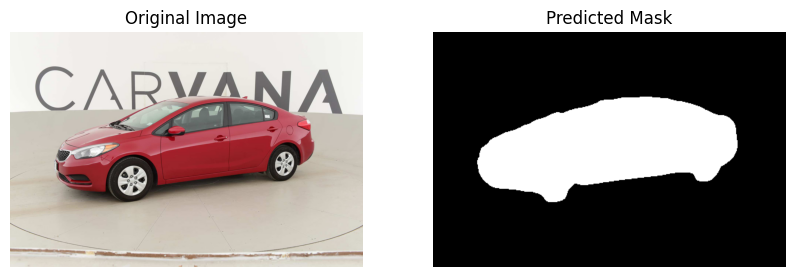

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\0a382e5373db_02.jpg_prediction.png


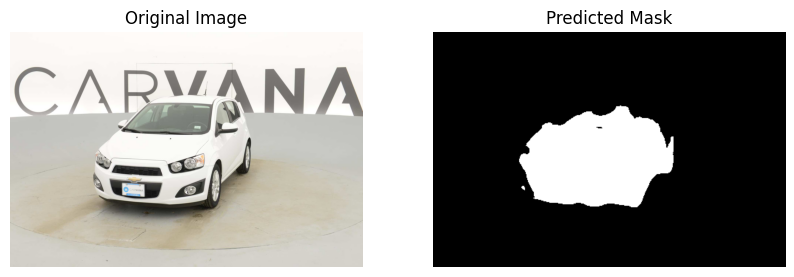

Saved combined image and mask at: runs/predict/exp_1/saved_predictions\0a84dac5df69_03.jpg_prediction.png


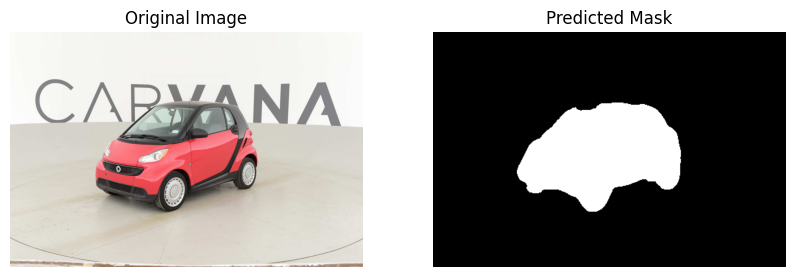

100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


In [47]:
# Predictions
all_predictions = []
basefolder=("runs")
folderpredict = create_unique_folders(basefolder+"/predict/exp")

for img_names, x in tqdm(test_loader):
    x = x.to(device)
    
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > THRESHOLD).float()  # Apply threshold to create binary mask
    
    # Resize the prediction to the original image size (1280x1918)
    preds_resized = TF.resize(
        preds, size=(1280, 1918), interpolation=TF.InterpolationMode.NEAREST
    )

    # Display each image along with its prediction
    for idx in range(len(img_names)):
        # Load original image (you can also fetch it directly from the dataset if needed)
        img_path = os.path.join(TEST_DIR, img_names[idx])
        original_img = np.array(Image.open(img_path).convert('RGB'))

        # Convert the predicted mask to CPU and numpy for visualization
        predicted_mask = preds_resized[idx].squeeze().cpu().numpy()

    


        # Display the original image and predicted mask
        display_predictions(original_img, predicted_mask,save_path= folderpredict + '/saved_predictions', img_name=img_names[idx])

        # Encode the predicted mask using run-length encoding
        encoding = rle_encode(predicted_mask)
        all_predictions.append([img_names[idx], encoding])